
=== Metrics for Each Target ===
                 Target           MSE       MAE         R2
0  SO2TONS_per_LOADMWBA  4.213406e-10  0.000014  -0.637125
1  SO2TONS_per_LOADMWBT  1.463655e-10  0.000001  -2.252077
2  NH3TONS_per_LOADMWBA  1.785770e-07  0.000175  -0.066256
3  NH3TONS_per_LOADMWBT  1.528508e-07  0.000033  -0.054419
4  NOXTONS_per_LOADMWBA  5.156498e-06  0.000411 -10.158552
5  NOXTONS_per_LOADMWBT  5.101233e-06  0.000177 -10.610637
6   COTONS_per_LOADMWBA  3.546570e-06  0.000247  -7.550469
7   COTONS_per_LOADMWBT  3.630470e-06  0.000158  -7.848756

=== Comparison for 2022-07-15 ===
                        Actual  Predicted
SO2TONS_per_LOADMWBA  0.000031   0.000040
SO2TONS_per_LOADMWBT  0.000003   0.000003
NH3TONS_per_LOADMWBA  0.000178   0.000349
NH3TONS_per_LOADMWBT  0.000015   0.000021
NOXTONS_per_LOADMWBA  0.000613   0.000779
NOXTONS_per_LOADMWBT  0.000051   0.000050
COTONS_per_LOADMWBA   0.000104   0.000164
COTONS_per_LOADMWBT   0.000009   0.000011

=== Feature Importance

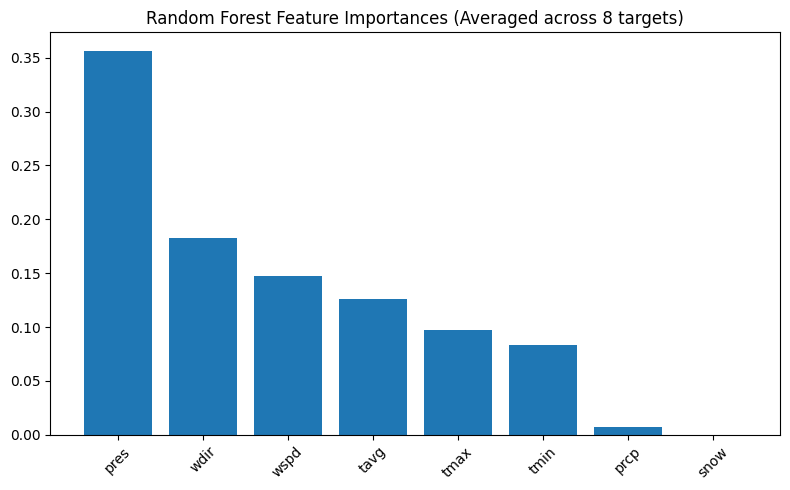

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor

# 1. Load Dataset
url = "https://raw.githubusercontent.com/apownukepcc/spring-2025-datathon/main/009-Dataset-For-Predictions-With-Specific-Emissions.csv"
df = pd.read_csv(url)

# 2. Convert date column and define a special test date
df['date'] = pd.to_datetime(df['date'])
specific_test_date = pd.to_datetime("2022-07-15")

if specific_test_date not in df['date'].values:
    raise ValueError(f"No data available for the date: {specific_test_date}")

# 3. Extract row for the specific test date, remove from main
specific_test_row = df[df['date'] == specific_test_date]
df = df[df['date'] != specific_test_date]

# 4. Define feature columns & target columns
feature_cols = ['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres']
target_cols = [
    'SO2TONS_per_LOADMWBA', 'SO2TONS_per_LOADMWBT',
    'NH3TONS_per_LOADMWBA', 'NH3TONS_per_LOADMWBT',
    'NOXTONS_per_LOADMWBA', 'NOXTONS_per_LOADMWBT',
    'COTONS_per_LOADMWBA', 'COTONS_per_LOADMWBT'
]

# Drop rows with missing feature/target values
df = df.dropna(subset=feature_cols + target_cols)

# 5. Train/Test Split
X = df[feature_cols]
y = df[target_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Append the specific test date row to the test set (for special comparison)
X_test = pd.concat([X_test, specific_test_row[feature_cols]])
y_test = pd.concat([y_test, specific_test_row[target_cols]])

# 6. Multi-Output Random Forest
base_rf = RandomForestRegressor(n_estimators=100, random_state=42)
multi_rf = MultiOutputRegressor(base_rf)
multi_rf.fit(X_train, y_train)

# 7. Predictions & Metrics
predictions = multi_rf.predict(X_test)

# Calculate a few metrics for each target
mse_all = mean_squared_error(y_test, predictions, multioutput='raw_values')
mae_all = mean_absolute_error(y_test, predictions, multioutput='raw_values')
r2_all  = r2_score(y_test, predictions, multioutput='raw_values')

results = pd.DataFrame({
    'Target': target_cols,
    'MSE': mse_all,
    'MAE': mae_all,
    'R2': r2_all
})

print("\n=== Metrics for Each Target ===")
print(results)

# Compare actual vs. predicted for the special date
pred_df = pd.DataFrame(predictions, columns=target_cols, index=y_test.index)
special_date_pred = pred_df.iloc[-1]
special_date_true = y_test.iloc[-1]
print(f"\n=== Comparison for {specific_test_date.date()} ===")
comparison_df = pd.DataFrame({'Actual': special_date_true, 'Predicted': special_date_pred})
print(comparison_df)

# 8. Feature Importances
# scikit-learn's MultiOutputRegressor trains one model per target;
# each model has its own feature_importances_, but we can average them
importances_per_model = []
for estimator in multi_rf.estimators_:
    importances_per_model.append(estimator.feature_importances_)

# Average over all target-specific models
avg_importances = np.mean(importances_per_model, axis=0)
sorted_idx = np.argsort(avg_importances)[::-1]  # sort descending

print("\n=== Feature Importances (Averaged Across Targets) ===")
for idx in sorted_idx:
    print(f"{feature_cols[idx]}: {avg_importances[idx]:.4f}")

# 9. Plot Feature Importances
plt.figure(figsize=(8, 5))
plt.bar(range(len(feature_cols)), avg_importances[sorted_idx], align='center')
plt.xticks(range(len(feature_cols)), [feature_cols[i] for i in sorted_idx], rotation=45)
plt.title("Random Forest Feature Importances (Averaged across 8 targets)")
plt.tight_layout()
plt.show()
